In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")
import quandl
import functools
import statsmodels.api as sm

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you make your own.

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

# 1 Introduction

A spread trading strategy checks a running estimate of the displacement between two related instruments, and makes bets that this displacement will decline whenever it gets large. Here, we define that displacement in terms of recent returns.

In [2]:
START_DATE    = "2019-12-02"
END_DATE      = "2021-12-31"

QUANDL_DB     = "QUOTEMEDIA/PRICES"
QUANDL_ASSETS = ["FCOM", "VOX"]

FF_TABLE      = "F-F_Research_Data_Factors_daily"
FF_DB         = "famafrench"

In [3]:
if "pull_quandl" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    @functools.lru_cache(maxsize=16)
    def pull_quandl(db, assets, start_date, end_date):
        ret = quandl.get_table(db, ticker=list(assets), 
                               date={"gte":START_DATE, "lte":END_DATE})
        return ret

eod_raw = pull_quandl(QUANDL_DB, tuple(QUANDL_ASSETS), START_DATE, END_DATE)
display(eod_raw.head(3))

Defining quandl pull


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,VOX,2021-12-31,136.8700,137.3300,135.5100,135.5600,78065.0000,0.0000,1.0000,136.8700,137.3300,135.5100,135.5600,78065.0000
1,VOX,2021-12-30,136.7800,137.9900,136.7800,137.1900,114214.0000,0.0000,1.0000,136.7800,137.9900,136.7800,137.1900,114214.0000
2,VOX,2021-12-29,137.1000,137.5300,136.0950,136.5000,97534.0000,0.0000,1.0000,137.1000,137.5300,136.0950,136.5000,97534.0000


In [4]:
ff_raw = pdr.data.DataReader(FF_TABLE, FF_DB, 
                            ''.join(START_DATE.split('-')),
                            ''.join(END_DATE.split('-')))

ff_raw[0].head(3)

,Mkt-RF,SMB,HML,RF
Date,,,,
2019-12-02,-0.8700,-0.2400,0.4600,0.0070
2019-12-03,-0.6600,0.6000,-0.8300,0.0070
2019-12-04,0.6000,0.1300,0.2500,0.0070


In [5]:
q_adj_close = eod_raw[["date", "ticker", "adj_close"]].pivot(
    index="date", columns="ticker", values="adj_close")
q_log_ret = np.log(q_adj_close / q_adj_close.shift(1))

f_ret = np.log(ff_raw[0] / 100 + 1)
f_ret.index.name = "date"
f_level = np.exp(f_ret.cumsum())

levels = q_adj_close.merge(f_level, how="left", on="date")
ret = q_log_ret.merge(f_ret, on="date")

etfs_facts = pd.concat([levels, ret], axis=1, keys=["level", "ret"])
display(etfs_facts)

level                                          ret          \
              FCOM      VOX Mkt-RF    SMB    HML     RF    FCOM     VOX   
date                                                                      
2019-12-02 34.0275  89.3003 0.9913 0.9976 1.0046 1.0001     NaN     NaN   
2019-12-03 34.0079  89.1632 0.9848 1.0036 0.9963 1.0001 -0.0006 -0.0015   
2019-12-04 34.1549  89.6723 0.9907 1.0049 0.9988 1.0002  0.0043  0.0057   
2019-12-05 34.2921  89.9464 0.9920 1.0028 1.0033 1.0003  0.0040  0.0031   
2019-12-06 34.5077  90.5143 1.0010 1.0052 1.0073 1.0004  0.0063  0.0063   
...            ...      ...    ...    ...    ...    ...     ...     ...   
2021-12-27 52.0700 137.4700    NaN    NaN    NaN    NaN     NaN     NaN   
2021-12-28 51.9700 137.2300    NaN    NaN    NaN    NaN     NaN     NaN   
2021-12-29 51.7500 136.5000    NaN    NaN    NaN    NaN     NaN     NaN   
2021-12-30 52.0000 137.1900    NaN    NaN    NaN    NaN     NaN     NaN   
2021-12-31 51.3600 135.5600    NaN    NaN    NaN    NaN     NaN     NaN   

                                           
            Mkt-RF     SMB     HML     RF  
date                                       
2019-12-02 -0.0087 -0.0024  0.0046 0.0001  
2019-12-03 -0.0066  0.0060 -0.0083 0.0001  
2019-12-04  0.0060  0.0013  0.0025 0.0001  
2019-12-05  0.0013 -0.0021  0.0046 0.0001  
2019-12-06  0.0091  0.0024  0.0039 0.0001  
...            ...     ...     ...    ...  
2021-12-27     NaN     NaN     NaN    NaN  
2021-12-28     NaN     NaN     NaN    NaN  
2021-12-29     NaN     NaN     NaN    NaN  
2021-12-30     NaN     NaN     NaN    NaN  
2021-12-31     NaN     NaN     NaN    NaN  

[526 rows x 12 columns]

# 2 Data

Obtain split- and dividend-adjusted closing prices1 for 2 Dec 2019 though 31 Dec 2021 of a pair of ETFs (which we will call X and Y ) as specified below. Estimate daily dollar volume, compute the running trailing 15-trading-day median of it over our sample period for X, and denote that running median (as of any day given t) for the less liquid of the two ETFs with the expression Nt.

In [6]:
q_adj_volm = eod_raw[["date", "ticker", "adj_volume"]].pivot(
    index="date", columns="ticker", values="adj_volume")

V_t = q_adj_volm * q_adj_close

window = 15

med = V_t.rolling(window).median().shift(1) # Shift to avoid lookahead bias
less_liquid = med.mean().idxmin()
N_t = med[less_liquid] # For position sizing
etfs_facts[("volm", "N_t")] = N_t
N_t[~N_t.isna()]

date
2019-12-23   1728917.1273
2019-12-24   1682752.4332
2019-12-26   1667148.7383
2019-12-27   1650773.4719
2019-12-30   1650773.4719
                 ...     
2021-12-27   4949595.1180
2021-12-28   4856834.6400
2021-12-29   4727868.5232
2021-12-30   4433092.9700
2021-12-31   4433092.9700
Name: FCOM, Length: 511, dtype: float64

# 3 Exercise 

## 3.1 Positions

Create code for a spread-reversion trading strategy that begins on the first day of each month, trades during the month, and closes any open positions the end of each month (i.e. the first potential day for a trade is just after January 1 2020). For this homework, make the unrealistic assumption that you can trade at end-of-day closing prices from the database.

Its trades are equal-sized dollar amounts of X and Y to the nearest integer number of shares, as close as possible to \\$ Nt / 100 of each. Note that Nt changes every day, so trade size will depend on which day you open the position. Your gross traded cash is therefore roughly \\$2Nt/100. Track this number on any open position for later stop loss calculations.

The strategy enters or maintains a position if the size s of difference between the M-day return on X and Y is greater than g, and flattens (exits) the position if the size of the difference is less than j (where j < g). It does so by shorting the security whose recent return is higher. Note that if the change in s is large enough the position can flip from shorting the spread to being long the spread and vice versa, as discussed in class.
You only ever hold, at most, one long and one short position (i.e. one spread position). If you already have a position and the next tick is favorable to it, this simply means you continue to hold the position (except in stop loss situations). Do not adjust position size with the new Nt.

## 3.2 Mark To Market

When a position is open, keep track of its profits/losses (PnL). You will also want to keep track of cumulative PL across the whole series of opened and closed positions.

## 3.3 Stop Loss

Include a stop loss parameter s in your strategy. If your simulation ex- periences a day such that the present position value has lost more than a proportion s of the gross traded cash (|$long| + |$short| at position entry time), then force an exit at current prices, assume no new positions for the remainder of the month, and include this in your accounting.

## 3.4 End Of Data

Force a position close at the end of the analysis period.

## 3.5 Capital

Set the capital K for your strategy to the maximum of Nt over the data
period, times two3. You can use this to evaluate return on capital.

## 3.6 Data

ETF pairs X,Y (in order) are as given by the last digit of your student number as follows:

My UCID ends with 0, so my pair is FCOM, VOX (Communication Services ETFs).

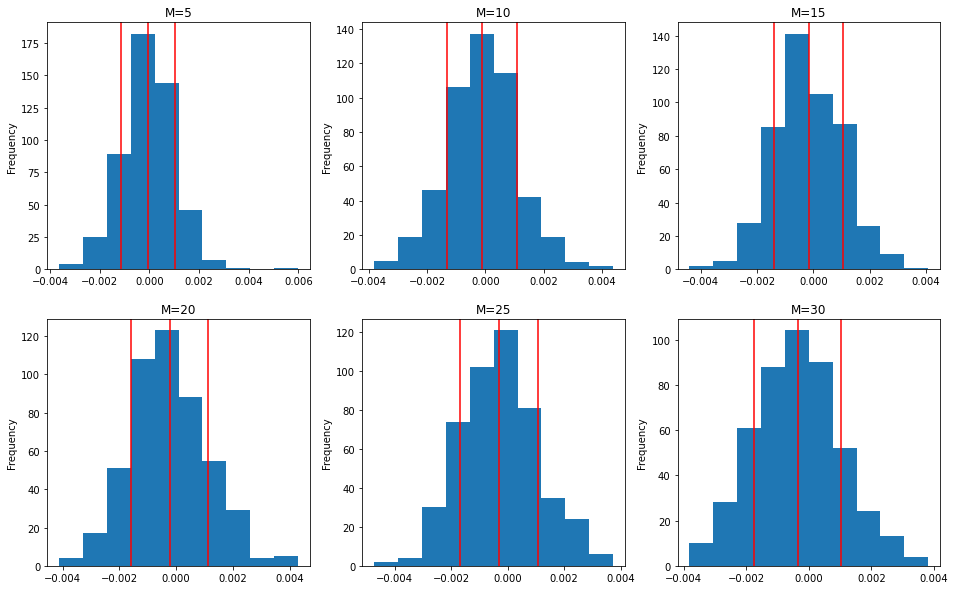

In [7]:
def construct_spread(data, assets, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    M: int                   accumulation window for spread"""
    strat = pd.DataFrame()
    for a, l in zip(assets, ["XR", "YR"]): strat[l] = data[("ret",a)]
    strat["tgt_size"] = data[("volm", "N_t")] / 100
    strat["signal"] = (strat["XR"].rolling(M).sum() 
                       - strat["YR"].rolling(M).sum())
    return strat
    
def vis_hist(ser, ax, stats):
    ser.plot.hist(ax=ax)
    mu = stats["mean"]; sig = stats["std"]
    ax.set_title(f"M={stats['M']}")
    ax.axvline(mu,c='r'); ax.axvline(mu+sig,c='r'); ax.axvline(mu-sig,c='r')

fig, axs = plt.subplots(2,3)
plt_counter = 0

strat_stats = []

for M in range(1,31):
    strat_ = construct_spread(etfs_facts, QUANDL_ASSETS, M)
    sig = strat_["signal"]
    
    ann = 252/M
    stats = {"M": M, "strat": strat_, "mean": sig.mean(), "std": sig.std(), 
             "amean": sig.mean()*ann, "astd": sig.std()*ann**0.5, "skew": sig.skew(),
             "kurt": sig.kurtosis()}
    strat_stats.append(stats)
    
    if not(M%5): # Plot every 5
        vis_hist(strat_["signal"], axs[plt_counter//3, plt_counter%3], stats)
        plt_counter += 1

strat_stats = pd.DataFrame(strat_stats).set_index('M')
plt.show()

## Histograms as `M` Increases

Decreasing Kurtosis (fatter tails), decreasing Mean. Increasing Standard Deviation.

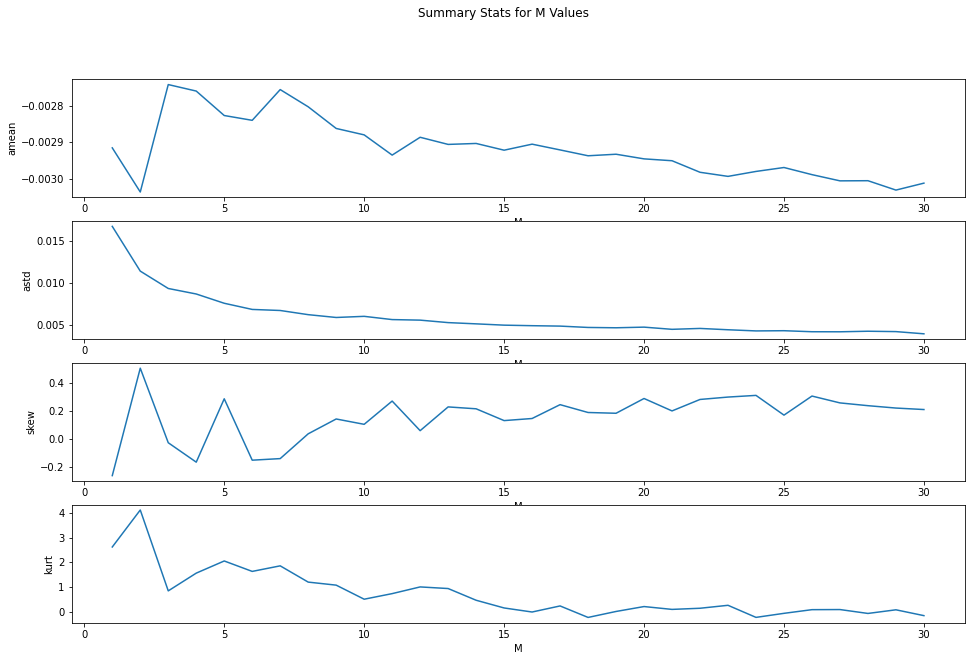

In [8]:
cols = strat_stats.columns[3:]
fig, axs = plt.subplots(len(cols))

for i, c in enumerate(cols):
    strat_stats[c].plot(ax=axs[i])
    axs[i].set_ylabel(c)
plt.suptitle("Summary Stats for M Values")
plt.show()

## Spread Summary Stats

Mean trends down, Standard Deviation trends up as $\sqrt{t}$. Skew and Kurtosis stabilize after 15.

Therefore, when tuning `g` and `j`, we should scale them according to $\sqrt{M}$

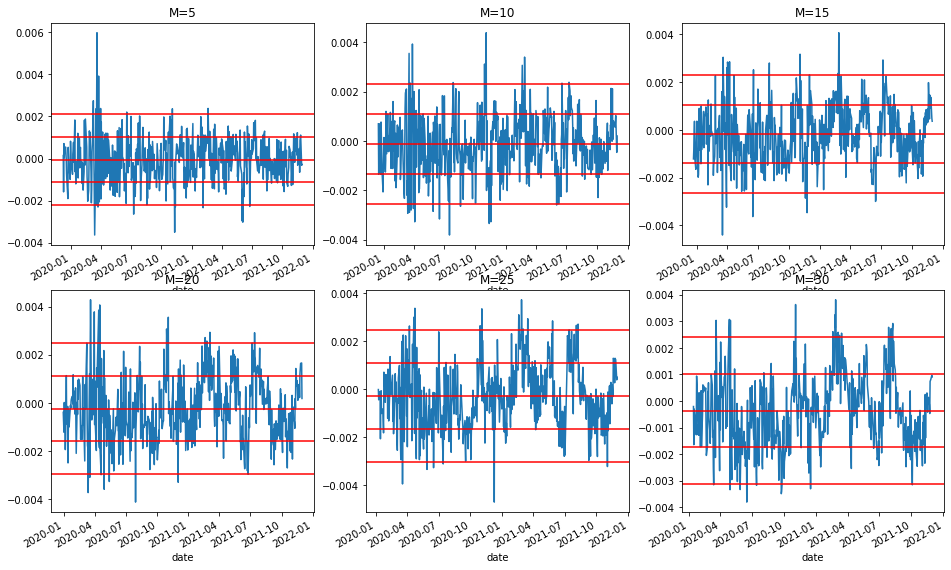

In [9]:
def ts_stats(row, ax):
    ser = row["strat"]["signal"]
    ser.plot(ax=ax)
    mu = row["mean"]; sig = row["std"]
    ax.set_title(f"M={row.name}")
    ax.axhline(mu,c='r'); ax.axhline(mu+sig,c='r'); ax.axhline(mu-sig,c='r')
    ax.axhline(mu+2*sig,c='r'); ax.axhline(mu-2*sig,c='r')

fig, axs = plt.subplots(2,3)

for i in range(6):
    ts_stats(strat_stats.loc[5*(i+1),:], axs[i//3,i%3])

plt.show()

## Spread $\mu$ and $\sigma$

Tune `g` and `j` to capture profit opportunities while not risking blowing up. `g` and `j` should be a function of $\sigma$(`M`), though we do not want to introduce lookahead bias.

`M` over 20 have spreads that cluster too significantly (reverts too slowly).

In [10]:
def construct_strategy(data, assets, g, j, s, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    g: float                 position entry parameter
    j: float                 position exit parameter
    s: float                 stop loss parameter
    M: int                   accumulation window for spread
    Constraint g > j > 0
    """
    # ---------------------------------------------------------------------
    def execute_strat(df, g=g, j=j, s=s, M=M):
        n = len(df)

        changes, positions = [], []
        dxs, dys, imbal = [], [], []
        x_pos, y_pos, profit = [], [], []

        # Starting day
        row = df.iloc[0]
        curr_chg = row["ltg"] - row["gtg"]
        curr_pos = curr_chg
        dx = curr_chg * row["XSz"]
        dy = -curr_chg* row["YSz"]
        imb = dx*row["XL"] + dy*row["YL"]
        x, y = 0, 0
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        dxs.append(dx), dys.append(dy)
        imbal.append(imb)
        x_pos.append(x); y_pos.append(y)

        for i in range(1, n-1):
            row = df.iloc[i]
            if curr_pos==0: # No position
                curr_chg = row["ltg"] - row["gtg"]
                if curr_chg:
                    dx = curr_chg * row["XSz"]
                    dy = -curr_chg* row["YSz"]
                else: dx, dy = 0, 0
                
            elif curr_pos>0: # Long position
                curr_chg = -row["gtj"] - row["gtg"]
                if curr_chg==0: dx, dy = 0,0
                elif curr_chg==-1: # Crosses -j: Close
                    dx, dy = -x, -y
                elif curr_chg==-2: # Crosses -j and +g: Reverse
                    dx = -row["gtg"]* row["XSz"] - x
                    dy = row["gtg"] * row["YSz"] - y
                    
            elif curr_pos<0: # Short position
                curr_chg = row["ltj"] + row["ltg"]
                if curr_chg==0: dx, dy = 0, 0
                elif curr_chg==1: # Crosses j: Close
                    dx, dy = -x, -y
                elif curr_chg==2: # Crosses j and -g: Reverse
                    dx = row["ltg"] * row["XSz"] - x
                    dy = -row["ltg"]* row["YSz"] - y
                    
            else: # Error
                pass
            
            x += dx
            y += dy
            curr_pos += curr_chg
            imb = dx*row["XL"] + dy*row["YL"]
            changes.append(curr_chg)
            positions.append(curr_pos)
            x_pos.append(x); y_pos.append(y)
            dxs.append(dx); dys.append(dy)
            imbal.append(imb)

        # Ending day
        row = df.iloc[-1]
        curr_chg = -curr_pos
        curr_pos += curr_chg
        dx, dy = -x, -y
        imb = dx*row["XL"] + dy*row["YL"]
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        x_pos.append(x); y_pos.append(y)
        dxs.append(dx); dys.append(dy)
        imbal.append(imb)

        trades = pd.DataFrame({"chg": changes, "pos": positions, 
                               "dX": dxs, "dY": dys,
                               "XPos": x_pos, "YPos": y_pos}, index=df.index)
        
        cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos']
        trades[cols] = trades[cols].fillna(0).astype(int)
        
        trades["XVal"] = trades["XPos"].shift(1) * df["XL"].diff()
        trades["YVal"] = trades["YPos"].shift(1) * df["YL"].diff()
        trades["pl"] = trades["XVal"] + trades["YVal"]
        trades["pl"].fillna(0, inplace=True)
        
        # gtc = gross trade cost
        trades["gtc"] = np.abs(trades["XPos"]*df["XL"]-trades["YPos"]*df["YL"])
        trades["ret"] = np.log(trades["pl"] / trades["gtc"].shift(1) + 1).fillna(0)
        
        trades["comcap"] = (trades["chg"]!=0).astype(int) * trades["gtc"]
        trades["comcap"] = trades["comcap"].replace(to_replace=0, method='ffill')
        trades["stop"] = trades["comcap"] * (1-s)
        trades["stopped"] = (trades["gtc"]<trades["stop"]) & (trades["gtc"]>0.0001)
        trades["stopped"] = trades["stopped"].replace(to_replace=0, method='ffill')

        return trades
    
    # ---------------------------------------------------------------------
    
    strat = construct_spread(data, assets, M)
    signal = strat["signal"]
    
    for a, l in zip(assets, ["XL", "YL"]): strat[l] = data[("level", a)]
    strat["XSz"] = np.round(strat["tgt_size"].divide(strat["XL"],axis=0))
    strat["YSz"] = np.round(strat["tgt_size"].divide(strat["YL"],axis=0))
    
    strat["gtg"] = signal > g
    strat["ltg"] = signal < -g
    strat["gtj"] = signal > -j
    strat["ltj"] = signal < j
    
    if True: # Debug
        to_ints = ["gtg", "ltg", "gtj", "ltj"]
        strat[to_ints] = strat[to_ints].astype(int)
    
    strat["year"] = strat.index.year
    strat["month"] = strat.index.month
    
    trades = strat.groupby(["year", "month"]).apply(execute_strat)
    
    strat = pd.concat([trades, strat], axis=1)
    
    K = 2 * strat["tgt_size"].max()
    # Return on capital
    strat["roc"] = np.log((strat["pl"]+K) / K)
    
    cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
            'pl', 'ret', 'roc']
    strat.loc[strat["stopped"], cols] = 0
    return strat

## First Test of Strategy

Using arbitrary parameters from a visual insepction of the spread plot (lookahead bias introduced here).

In [11]:
g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 10      # Accumulation window to determine spread divergence

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
mask = (strat["year"]==2020) & (strat["month"]==1)

cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
        'signal', 'XL', 'YL', 'pl', 'gtc', 'stop', 'ret']
strat[mask][cols].head()

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,pl,gtc,stop,ret
date,,,,,,,,,,,,,
2020-01-02,0,0,0,0,0,0,0.0001,35.5481,93.3144,0.0000,0.0000,0.0000,0.0000
2020-01-03,0,0,0,0,0,0,-0.0007,35.4008,92.9412,-0.0000,0.0000,0.0000,0.0000
2020-01-06,1,1,489,-186,489,-186,-0.0013,35.7838,94.0411,0.0000,34989.9404,34640.0410,0.0000
2020-01-07,0,1,0,0,489,-186,-0.0008,35.8231,94.1000,8.2534,35020.1131,34640.0410,0.0002
2020-01-08,-2,-1,-994,378,-505,192,0.0012,36.0392,94.5812,16.1678,36359.4040,35995.8099,0.0005


In [12]:
stop_mask = (strat["stopped"]&(~strat["stopped"].shift(1, fill_value=False)))
strat[stop_mask][cols].head()

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,pl,gtc,stop,ret
date,,,,,,,,,,,,,
2020-01-24,0,0,0,0,0,0,-0.0002,36.5304,95.8383,0.0000,75158.3306,75221.4608,0.0000
2020-02-21,0,0,0,0,0,0,-0.0012,36.8840,96.9971,0.0000,69981.9463,70271.3032,0.0000
2020-03-03,0,0,0,0,0,0,-0.0023,33.2496,87.4614,0.0000,71889.4365,73465.6917,0.0000
2020-06-24,0,0,0,0,0,0,-0.0003,35.1060,92.3690,0.0000,73193.6847,73590.5076,0.0000
2020-07-13,0,0,0,0,0,0,-0.0024,36.2815,95.7039,0.0000,54450.4146,55042.0396,0.0000


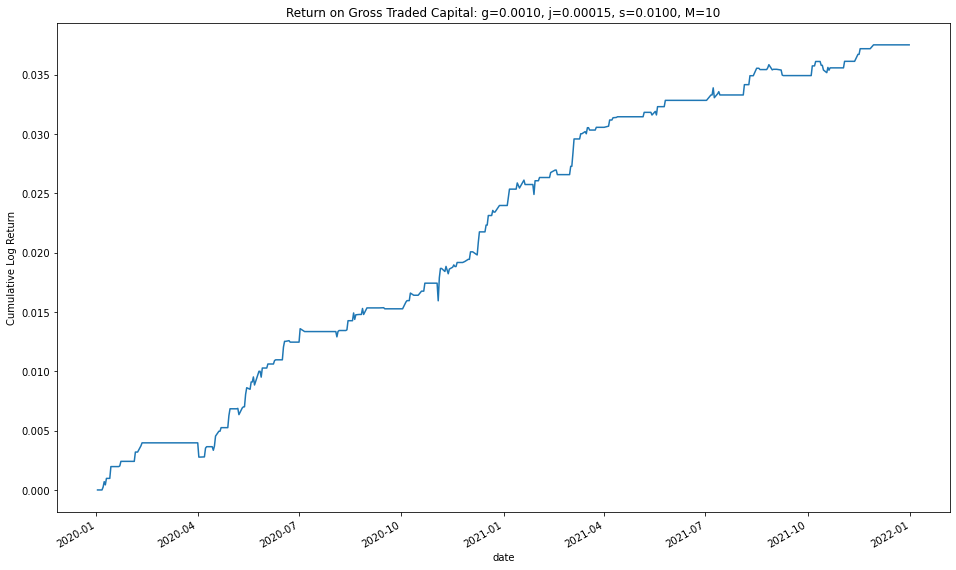

In [13]:
strat["2020":]["ret"].cumsum().plot()
plt.title(f"Return on Gross Traded Capital: g={g:.4f}, j={j:.5f}, s={s:.4f}, M={M}")
plt.ylabel("Cumulative Log Return")
plt.show()

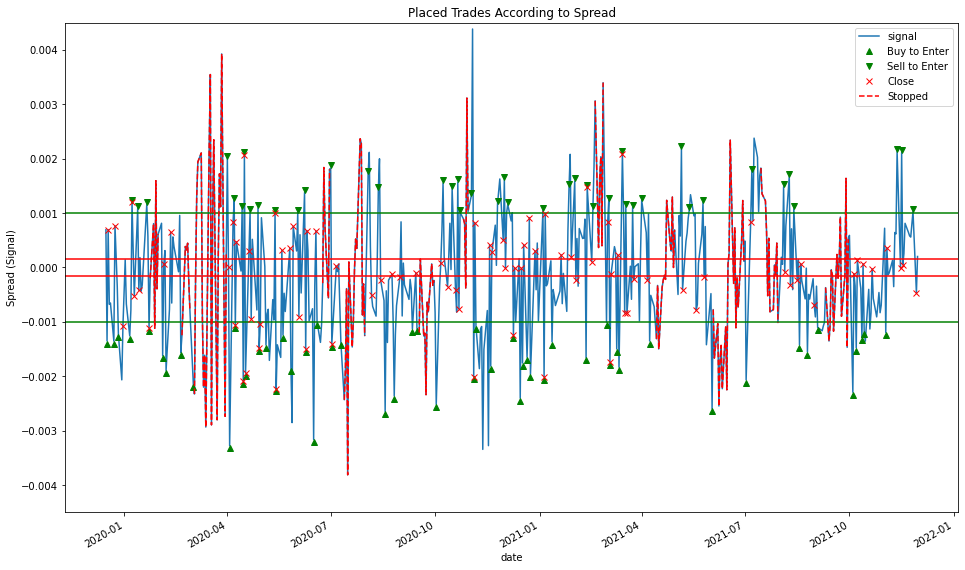

In [14]:
def visualize_strat(strat, g, j, ep=0.00005, yl=0.0045):
    fig, ax = plt.subplots()
    ax.set_ylim([-yl,yl])
    
    strat["signal"].plot(ax=ax)
    ax.axhline(g, c="g"); ax.axhline(-g, c="g")
    ax.axhline(j, c="r"); ax.axhline(-j, c="r")
    
    buy_to_enter = (strat["chg"]==1) & (strat["pos"].shift(1)==0)
    sell_to_enter = (strat["chg"]==-1) & (strat["pos"].shift(1)==0)
    buy_to_close = (strat["chg"]==1) & (strat["pos"].shift(1)!=0)
    sell_to_close = (strat["chg"]==-1) & (strat["pos"].shift(1)!=0)
    reverse_up = strat["chg"]==2
    reverse_down = strat["chg"]==-2
    
    ax.plot(strat.loc[buy_to_enter,"signal"]-ep, marker='^', ls='', color='g', label="Buy to Enter")
    ax.plot(strat.loc[buy_to_close,"signal"], marker='x', ls='', color='r')
    ax.plot(strat.loc[sell_to_enter,"signal"]+ep, marker='v', ls='', color='g', label="Sell to Enter")
    ax.plot(strat.loc[sell_to_close,"signal"], marker='x', ls='', color='r', label="Close")
    ax.plot(strat.loc[reverse_up,"signal"]-ep, marker='^', ls='', color='g')
    ax.plot(strat.loc[reverse_down,"signal"]+ep, marker='v', ls='', color='g')
    ax.plot(strat.loc[reverse_up,"signal"], marker='x', ls='', color='r')
    ax.plot(strat.loc[reverse_down,"signal"], marker='x', ls='', color='r')
    stopped = strat[["stopped", "signal"]].copy(deep=True)
    stopped[~stopped["stopped"]] = np.nan
    ax.plot(stopped["signal"], ls='--', color='r', label="Stopped")
    plt.title("Placed Trades According to Spread")
    plt.ylabel("Spread (Signal)")
    plt.legend()
    plt.show()
    
visualize_strat(strat, g, j)

## Tune Accumulation Window `M`

`M` impacts signal strength and balances information against overtrading. Higher `M` leads to the failure to respond accurately to signals due to the high amount of spread data accumulation.

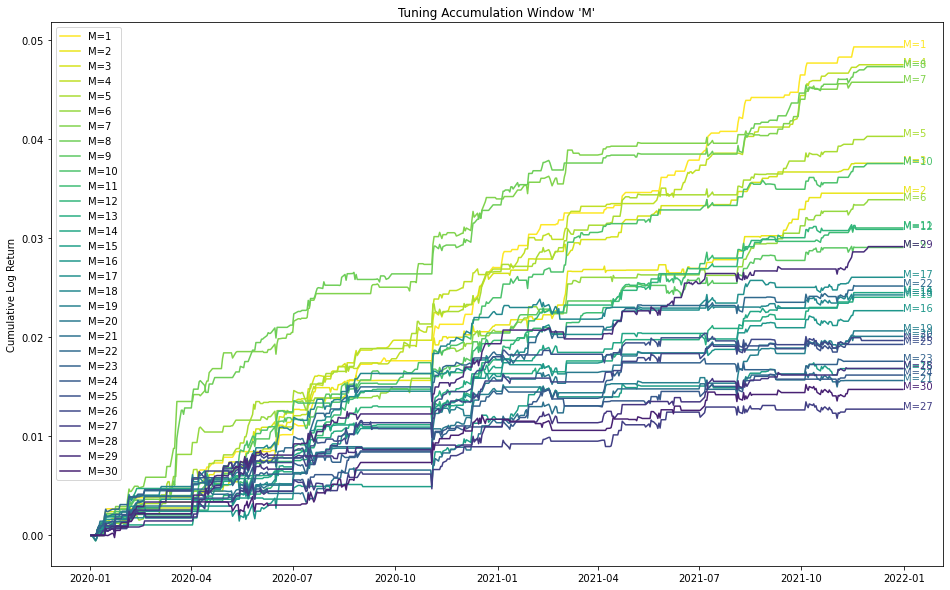

In [15]:
g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
# M = 10      # Accumulation window to determine spread divergence

fig, ax = plt.subplots()

minim = 1
maxim = 31
Ms = range(minim,maxim)

for i, M in enumerate(Ms):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*8)
    ax.plot(plot_ser, c=colo, label=f"M={M}")
    ax.annotate(f"M={M}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Cumulative Log Return")

plt.title("Tuning Accumulation Window 'M'")
plt.legend()
plt.show()

## Tune Entry Parameter `g`

`g` $\in [0.0006, 0.0007, 0.0008, 0.0009]$ yields the highest return. We observe that a strategy with `g` too high or too low will have depressed returns because it trades too infrequently or too foolishly, respectively.

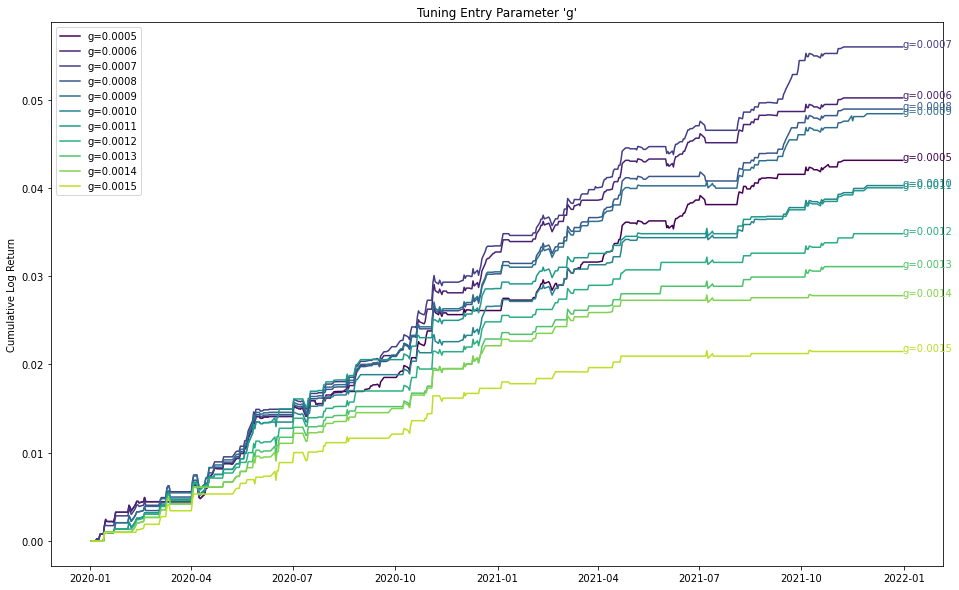

In [16]:
# g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

fig, ax = plt.subplots()

minim = 0.0005
maxim = 0.0015
gs = np.linspace(minim, maxim, 11)

for i, g in enumerate(gs):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(i*23)
    ax.plot(plot_ser, c=colo, label=f"g={g:.4f}")
    ax.annotate(f"g={g:.4f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Cumulative Log Return")

plt.title("Tuning Entry Parameter 'g'")
plt.legend()
plt.show()

## Tune Exit Parameter `j`

`j` tuning tends to be consistent, as long as its value is not set too small (i.e `j` < 0.00020). `j` > 0.00050 indeed returns higher than the lower values, but this is solely attributed to a few trades in March 2020. Its out of sample performance may not be robust in this case. Therefore we choose a parameter near the middle of the distribution.

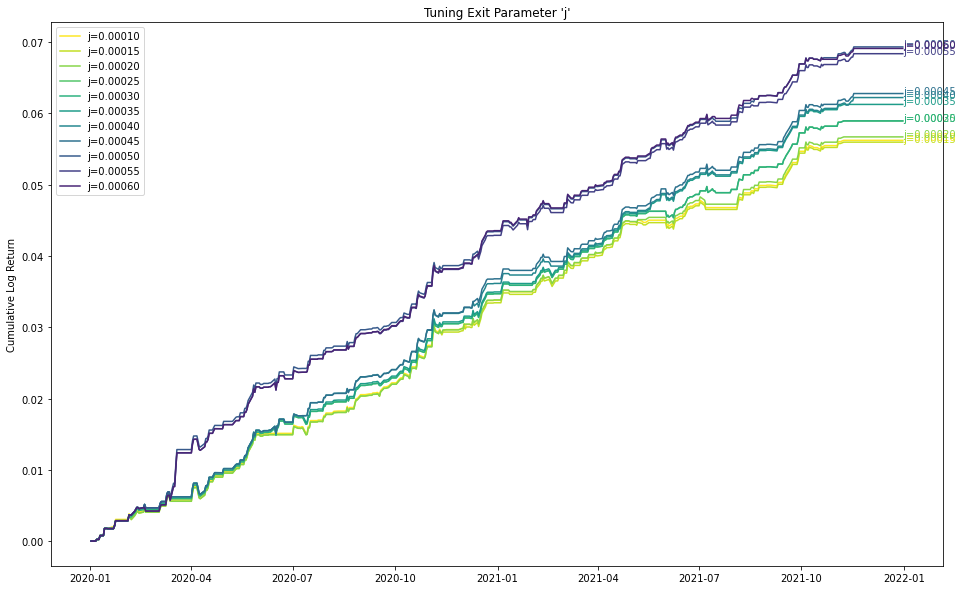

In [17]:
g = 0.0007  # Entry parameter
# j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

fig, ax = plt.subplots()

minim = 0.0001
maxim = 0.0006
js = np.linspace(minim, maxim, 11)

for i, j in enumerate(js):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*23)
    ax.plot(plot_ser, c=colo, label=f"j={j:.5f}")
    ax.annotate(f"j={j:.5f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Cumulative Log Return")

plt.title("Tuning Exit Parameter 'j'")
plt.legend()
plt.show()

## Tune Stop Loss Parameter `s`

`s` measures the strategy's volatility averseness. However, taking no risk leads to no reward, as we see in `s`=0.0000 (closes the position if next day moves against the strategy). Therefore, it is important to balance the `s` thresshold to disallow catastrophic drawdowns. We observe a diminishing return with `s` > 0.0500.

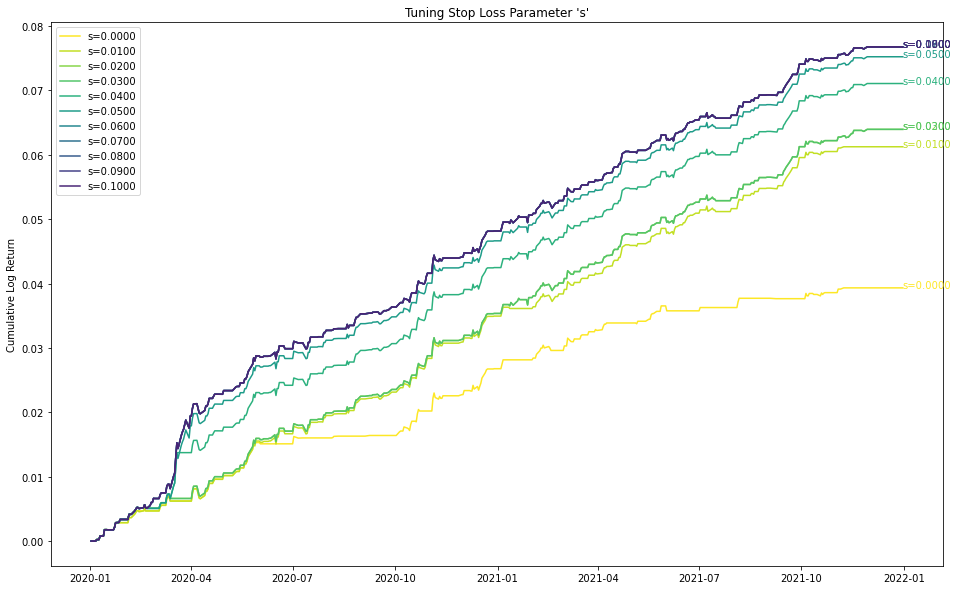

In [18]:
g = 0.0007  # Entry parameter
j = 0.00035 # Exit parameter
# s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

fig, ax = plt.subplots()

minim = 0.0
maxim = 0.1
ss = np.linspace(minim, maxim, 11)

for i, s in enumerate(ss):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*23)
    ax.plot(plot_ser, c=colo, label=f"s={s:.4f}")
    ax.annotate(f"s={s:.4f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Cumulative Log Return")

plt.title("Tuning Stop Loss Parameter 's'")
plt.legend()
plt.show()

## Tuned Strategy

The following parameters were chosen to maximize profit while remaining robust.

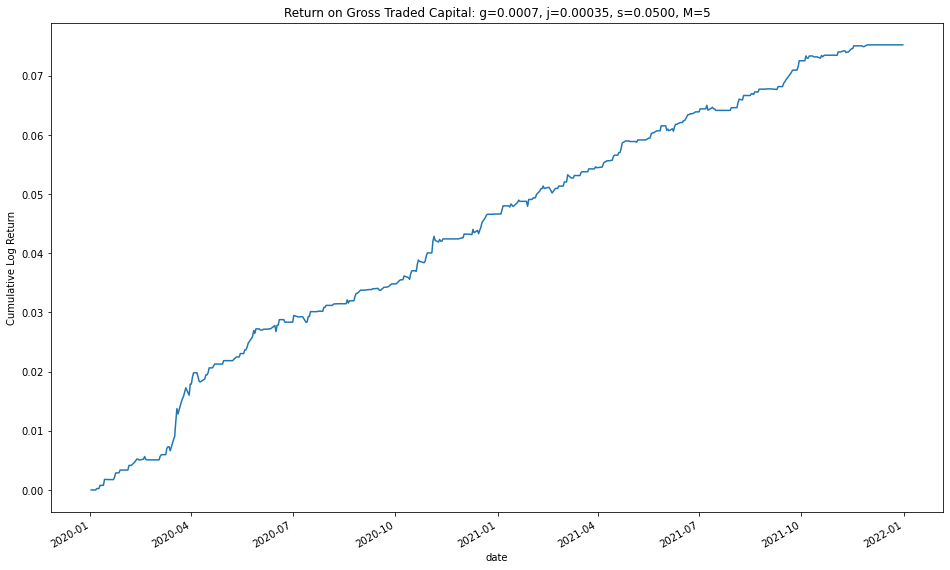

In [19]:
g = 0.0007  # Entry parameter
j = 0.00035 # Exit parameter
s = 0.05    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
strat["2020":]["ret"].cumsum().plot()
plt.title(f"Return on Gross Traded Capital: g={g:.4f}, j={j:.5f}, s={s:.4f}, M={M}")
plt.ylabel("Cumulative Log Return")
plt.show()

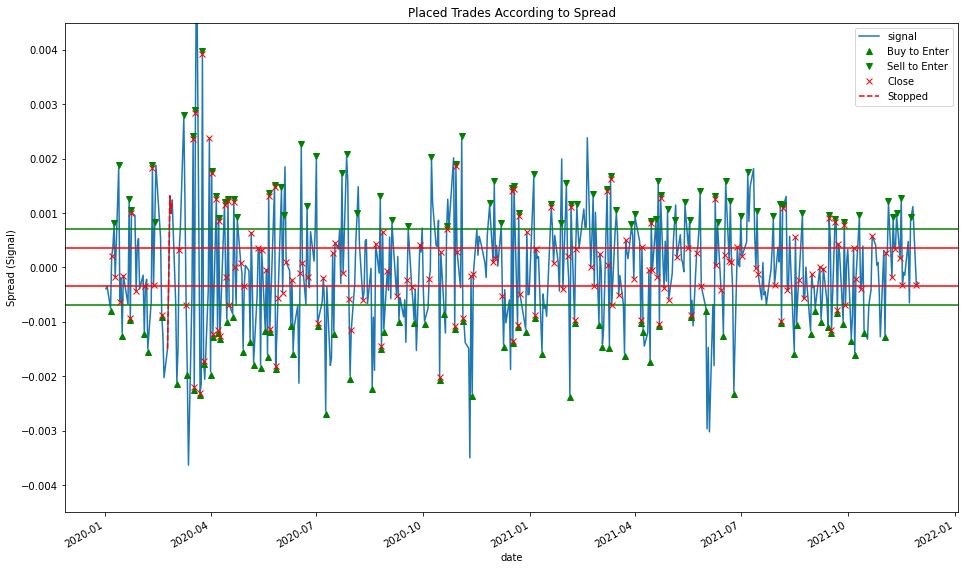

In [20]:
visualize_strat(strat["2020":], g, j)

# 4 Analysis

Study the performance of your strategy as you vary j, g, s, and M. Include plots. You need not run a fancy nonlinear optimizer, but try to find which parameters work well, and explain how you did it. For one or more of the better settings you find, look into correlations to Fama French factor returns.
Be sure to highlight which ETF pair you are analyzing.

## Trade Analysis

The above trade plot details the entry, exists, reversals, and stops of the strategy. Notably, the strategy hit stop loss at March 2020. Furthermore, it is important to see that `g` and `j` parameters are set relatively close together. This setting is in response to the spread's tendency to "bounce" (negative autoregression, strong mean reversion).

In [21]:
factors = etfs_facts["ret"].columns[2:-1]

decomp = strat["2020":][["ret", "roc"]].merge(etfs_facts["ret"][factors], on="date").dropna()
decomp.head(3)

,ret,roc,Mkt-RF,SMB,HML
date,,,,,
2020-01-02,0.0000,0.0000,0.0086,-0.0089,-0.0032
2020-01-03,0.0000,0.0000,-0.0067,0.0039,0.0000
2020-01-06,0.0000,0.0000,0.0036,-0.0007,-0.0054


In [22]:
endo = decomp[["roc"]]
exog = sm.add_constant(decomp[factors])

res = sm.OLS(endo, exog).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roc   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.541
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           0.000242
Time:                        16:55:33   Log-Likelihood:                 3262.5
No. Observations:                 483   AIC:                            -6517.
Df Residuals:                     479   BIC:                            -6500.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.744e-05   1.29e-05      6.772      0.000    6.21e-05       0.000
Mkt-RF        -0.0023      0.001     -2.895      0.004      -0.004      -0.001
SMB            0.0040      0.002      2.599      0.010       0.001       0.007
HML           -0.0022      0.001     -2.332      0.020      -0.004      -0.000
==============================================================================
Omnibus:                      372.888   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9424.114
Skew:                           3.083   Prob(JB):                         0.00
Kurtosis:                      23.742   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Analysis

The Linear Factor Decomposition using the Fama-French 3-Factor model yields a hedging $R^2$ of 0.04. The strategy is significantly explained by Market, SMB and HML factors. It is worthy to note that the coefficients are extremely small because the spread stragegy has low returns comapred with the factors.

In [23]:
def sharpe(ser, ann=252):
    return ann**0.5 * ser.mean() / ser.std()

def info_ratio(alpha, res_std, ann=252):
    return ann**0.5 * alpha / res_std

alpha = res.params[0] * 252          # Annualized
res_std = res.resid.std() * 252**0.5 # Annualized
sr = sharpe(decomp["ret"], ann=252)
ir = info_ratio(alpha, res_std, ann=1)

print(f"Portable alpha    = {alpha:.4f}")
print(f"Sharpe Ratio      = {sr:.4f}")
print(f"Information Ratio = {ir:.4f}")

Portable alpha    = 0.0220
Sharpe Ratio      = 5.9842
Information Ratio = 4.9175
